In [1]:
import uproot
import numpy as np
import awkward as ak

from coffea.nanoevents import NanoEventsFactory, BaseSchema
from agc_schema import AGCSchema

In [2]:
import json
with open('ntuples.json', 'r') as f:
    metadata = json.load(f)

# Function to calculate the integrated luminosity in case we couldn't access all of the files
def getLumi(nevts):
    lumi_nom = 2256.38 # total possible luminosity in /pb
    sf = float(nevts)/36619019
    return lumi_nom*sf 

# Useful function to calculate weight, pass the sample name, 
# total_events summed over files accessed and lumi calculated from function above
def getEventWeight(sample,n_total_events,lumi):
    if sample != "data": # we don't weight the real data
        xsec_weight = metadata[sample]['filter_eff']*metadata[sample]['xsec'] * lumi / (n_total_events)
    else:
        xsec_weight = 1
    return xsec_weight

In [3]:
# define the binning for my observable (m_bjj)
obsbins=np.arange(50,575,25)

In [4]:
# define a function that will run over the analysis for any input file 

import time
import matplotlib.pyplot as plt

def runAnalysis(input_file):
    try: 
        events = NanoEventsFactory.from_root(input_file, schemaclass=AGCSchema, treepath='events').events()
    except OSError:
        time.sleep(2) # sleep for 2 seconds and try one more time
        try: 
            events = NanoEventsFactory.from_root(input_file, schemaclass=AGCSchema, treepath='events').events()
        except OSError:
            time.sleep(2) # sleep for 2 seconds just to not try EOS again but give up on this file now
            return []
    
    # Object selection
    selected_electrons = events.electron[(events.electron.pt > 30) & (abs(events.electron.eta)<2.1) & (events.electron.isTight == True) & (events.electron.sip3d < 4 )]
    selected_muons = events.muon[(events.muon.pt > 30) & (abs(events.muon.eta)<2.1) & (events.muon.isTight == True) & (events.muon.sip3d < 4) & (events.muon.pfreliso04DBCorr < 0.15)]
    selected_jets = events.jet[(events.jet.corrpt > 30) & (abs(events.jet.eta)<2.4) ]
    
    # Event selection
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    event_filters = event_filters &  (ak.count(selected_jets.corrpt, axis=1) >= 4) & (ak.sum(selected_jets.btag >= 0.8, axis=1) >= 2)
    selected_events = selected_jets[event_filters]
    
    # Calculate observable 
    trijet = ak.combinations(selected_events, 3, fields=["j1", "j2", "j3"])
    j1,j2,j3 = ak.unzip(trijet)
    has_bjet = (ak.sum(j1.btag>=0.8,axis=1)+ak.sum(j2.btag>=0.8,axis=1)+ak.sum(j3.btag>=0.8,axis=1)>0)
    trijet = trijet[has_bjet]
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable = ak.flatten(trijet_mass).to_numpy()
    
    # create counts in bins 
    counts_bin_edges  = plt.hist(observable,bins=obsbins)
    counts, bin_edges = counts_bin_edges[0],counts_bin_edges[1]
    plt.clf()
    
    # return the counts 
    return np.array(counts)


In [5]:
from hist2df import * 

samples=[
    'data'
    ,'ttbar'
    ,'single_atop_t_chan'
    ,'single_top_t_chan'
    ,'single_top_tW'
    ,'wjets'
]


n_sim_samples = len(samples)-1

# first run over the data. We want to keep track of the total number of events 
# that get accessed so that we can modify the integrated luminosity if necessary 

print('data')
counts = np.array([0. for i in range(len(obsbins)-1)])
total_events = 0

MAX_FILES = -1 # if a negative number, then we don't set a maximum on the number of files. 

for j,p in enumerate(metadata['data']['nominal']['files']): 
    
    # for each file, we add the counts from these events
    if (MAX_FILES > 0 and j > MAX_FILES): continue
    print(j,p['path'])

    event_counts = runAnalysis(p['path'])
    if len(event_counts):
        counts += event_counts 
        total_events+=p['nevts'] 
 
    else : print("skipped file (XRootD error)")
    

intlumi = getLumi(total_events)
print("Data total events accessed", total_events, " -> %g /pb"%intlumi )
                 
# convert to dataframe 
dfs = histogramToDataframe(counts,"signalregion",'data')
                
# Now we run over the simulated samples. Again, we should keep track of the number of events  
# that get accessed so that we can calculate the right event_weight

for i,sample in enumerate(samples[1:]): 
    if sample=='data': continue # shouldn't need this 
    print(sample)
    
    # make sure to zero out the counts for each sample 
    counts = np.array([0. for i in range(len(obsbins)-1)])
    total_sim_events = 0
    
    for j,p in enumerate(metadata[sample]['nominal']['files']): 
        
        if (MAX_FILES > 0 and j > MAX_FILES): continue
        print(j,p['path'])
        # for each file, we add the counts from these events
        event_counts = runAnalysis(p['path'])
        if len(event_counts):
            counts += event_counts 
            total_sim_events+=p['nevts'] 
           
        else : print("skipped file (XRootD error)")
        
            
    event_weight = getEventWeight(sample,total_sim_events,intlumi)
    print("Total events processed (%s):"%(sample), total_sim_events, 
          "XSec = ",metadata[sample]['xsec'], 
          "Filter efficiency = ", metadata[sample]['filter_eff'], 
          "Event weight = ", event_weight)
        
    # now that we have the counts, we convert to a dataframe 
    dfs_sample = histogramToDataframe(counts,"signalregion",sample)
    
    # apply weight to columns
    dfs_sample['sum_w']*=event_weight
    dfs_sample['sum_ww']*=event_weight*event_weight
    
    # add the new sample into our dataframe
    dfs = pd.concat([dfs,dfs_sample],ignore_index=True)


data
0 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/07FC2CD2-106C-4419-9260-12B3E271C345_flat.root
1 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/0935DABA-2ECA-4F6B-A880-34594A5AE8FA_flat.root
2 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/0B54B6B7-3F0C-4106-BEF6-C64CDE42CB72_flat.root
3 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/1130E0AD-1ED1-4B31-AC3E-DC61B5D79552_flat.root
4 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/12FBD489-A0D5-4DCF-AE97-59C79EE59964_flat.root
5 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/147AD171-2B23-4E8D-83FF-0D632170BA4E_flat.root
6 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/Run2015D_SingleMuon_flat/16C24360-0D8E-4FC1-8FC3-D92

/usr/local/venv/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


2 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/098147D8-1FF6-4075-B55A-5784BAD842AB_flat.root
skipped file (XRootD error)
3 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/0A514982-0995-497E-9B65-B754B4B0E796_flat.root
4 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/0A688F77-7EA0-4935-B33C-56CE7AA786E2_flat.root
5 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/0C031340-8011-496F-BADB-30D042E09228_flat.root
6 root://eospublic.cern.ch//eos/opendata/cms/derived-data/POET/23-Jul-22/RunIIFall15MiniAODv2_TT_TuneCUETP8M1_13TeV-powheg-pythia8_flat/12D782DF-337C-41E0-98F2-7E9B10E9B932_flat.root
7 root://eospublic.cern.ch//eos/opendata/cms/derived-data

<Figure size 432x288 with 0 Axes>

[117.68369660137687, 820.7912811540181, 2586.688429115161, 5330.962561676713, 8375.240671628557, 10145.415812526298, 9429.027004447758, 7953.3527863900445, 6519.136208972472, 5269.923380640407, 4224.498579470013, 3358.2633460758407, 2697.91624546676, 2168.125711113734, 1738.5763294342205, 1403.3955828516143, 1147.4354872858635, 932.8746960929368, 774.880638775325, 646.2102784958619]
Integrated luminosity =  2256.38  /pb


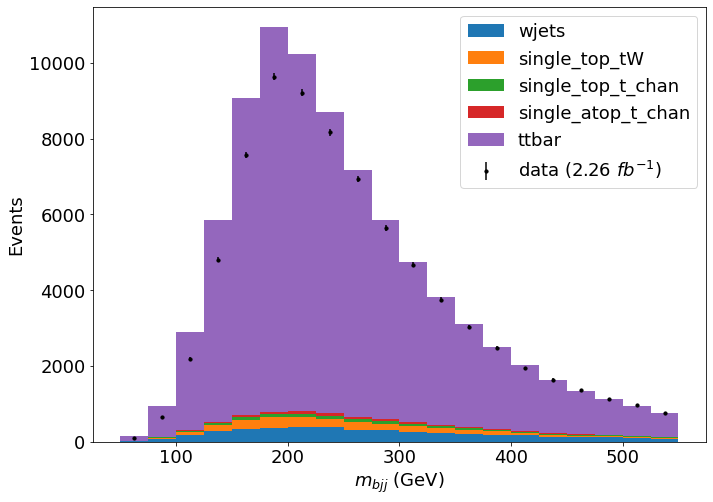

In [6]:
plt.rcParams.update({'font.size': 18})

order_sim = samples[1:]
order_sim.reverse() # plot stack in reverse 

# need to make list structures for this to work in stacked mode 
bin_centres = np.array(obsbins[0:-1])+25./2
bins_list = [obsbins[0:-1] for b in range(n_sim_samples)]
samples_stack = [dfs[dfs['process']==s]['sum_w'].to_list() for s in order_sim]
labels = order_sim

print(dfs[dfs['process']=='ttbar']['sum_w'].to_list())

plt.figure(figsize=(11,8))

plt.hist(bins_list,bins=obsbins,weights=samples_stack,label=labels,stacked=True,density=False)
plt.errorbar(bin_centres,dfs[dfs['process']=='data']['sum_w']
             ,yerr=(dfs[dfs['process']=='data']['sum_ww'])**0.5
             ,label='data (%.2f $fb^{-1}$)'%(intlumi/1000)
             ,marker='o'
             ,markersize=3.2
             ,color='black'
             ,linestyle="none")
plt.xlabel("$m_{bjj}$ (GeV)")
plt.ylabel("Events")

plt.legend()
print("Integrated luminosity = ", intlumi," /pb")

plt.savefig("mbjj_signalregion.png")

In [7]:
# Finally save histograms to a csv file

dfs.to_csv('signalregion_mbjj.csv',index=False)